# <b><center> Test Technique KPMG: </center></b>
# <center><i> Optimisation de l'Extraction de Données des Rapports SFCR : Classification Automatique et Visualisation PDF <span style="color:#DC143C;"> </center>


  
  <p align="right">
  <img src=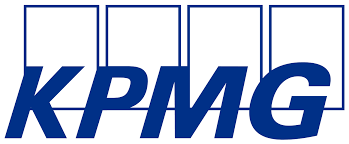 alt="Quantmetry Logo" width="300">
</p>


<i align="left">Made by: CHENBEH Rayen</i>

In [11]:
!pip install fitz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.3 MB/s eta 0:00:00


In [5]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 30.7 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import pandas as pd
import numpy as np
import json
import fitz

In [156]:
data_path='allianz'
#data_path='axa'
#data_path='camca'
#data_path='covea'

#**Améliorer la Fonction de Filtrage : produce_brut()**

In [157]:
def produce_brut(data_path):
    with open('/content/drive/MyDrive/test-technique-main/data/ocr/{}.json'.format(data_path), 'r',encoding="utf8") as f:
        data = json.load(f)
    pages_content=data["responses"]
    num_page=0
    df=[]
    for page in pages_content:
        num_page+=1
        if "fullTextAnnotation" not in page:
            continue
        p=page["fullTextAnnotation"]["pages"]
        for e in p:
            blocks=e["blocks"]
            page_features=[]
            for block in blocks:
                for para in block["paragraphs"]:
                    # collect text
                    text = ""
                    for word in para["words"]:
                        #print("-----")
                        #print(word)
                        for symbol in word["symbols"]:
                            if symbol["confidence"]>=0.8:
                                text += symbol["text"]
                        text+=" "
                    # extract bounding box features
                    x_list = []
                    y_list = []
                    for v in para["boundingBox"]["normalizedVertices"]:
                        x_list.append(v["x"])
                        y_list.append(v["y"])
                    f = {}
                    f["num_page"]=num_page
                    f["text"] = text
                    f["width"] = max(x_list) - min(x_list)
                    f["height"] = max(y_list) - min(y_list)
                    f["area"] = f["width"] * f["height"]
                    f["chars"] = len(text)

                    f['digit_count'] = sum(c.isdigit() for c in text)

                    f["char_size"] = f["area"] / f["chars"] if f["chars"] > 0 else 0
                    f["pos_x"] = (f["width"] / 2.0) + min(x_list)
                    f["pos_y"] = (f["height"] / 2.0) + min(y_list)
                    f["aspect"] = f["width"] / f["height"] if f["height"] > 0 else 0
                    f["layout"] = "h" if f["aspect"] > 1 else "v"
                    f["x0"]=x_list[0]
                    f["x1"]=x_list[1]
                    f["y0"]=y_list[0]
                    f["y1"]=y_list[1]
                    page_features.append(f)
            df=df+page_features
    df=pd.DataFrame(df)
    df["assureur"]=data_path
    return df

"J'ai ajouté une nouvelle caractéristique nommée 'digit_count' qui représente le nombre de chiffres dans le texte extrait. Cette fonctionnalité a significativement amélioré les résultats, en particulier pour l'extraction des tableaux. En effet, elle permet de distinguer plus efficacement les segments de texte contenant des données chiffrées, souvent présentes dans les tableaux, des autres types de contenu."



In [158]:
df = produce_brut(data_path)
df.to_excel("/content/drive/MyDrive/test-technique-main/data/results/{}.xlsx".format(data_path), index=False)

#**Visualisation des Caractéristiques Clés : Analyse Graphique**

In [159]:
df.head()

,num_page,text,width,height,area,chars,digit_count,char_size,pos_x,pos_y,aspect,layout,x0,x1,y0,y1,assureur
0,1,COVÉA,0.123675,0.026144,0.003233,6,0,0.000539,0.280919,0.218301,4.730565,h,0.219081,0.340989,0.206536,0.205229,covea
1,1,RAPPORT SUR LA SOLVABILITÉ ET LA SITUATION FIN...,0.524735,0.077124,0.040470,59,4,0.000686,0.481449,0.269935,6.803767,h,0.219081,0.743816,0.232680,0.231373,covea
2,1,CO vea,0.098940,0.062745,0.006208,7,0,0.000887,0.839223,0.870588,1.576855,h,0.789753,0.888693,0.839216,0.839216,covea
3,2,Sommaire,0.188235,0.020214,0.003805,9,0,0.000423,0.211765,0.102854,9.312111,h,0.117647,0.305882,0.093936,0.092747,covea
4,2,Synthèse ...,0.122689,0.013080,0.001605,13,0,0.000123,0.178992,0.170630,9.380136,h,0.117647,0.240336,0.164090,0.164090,covea


In [160]:
df.describe()

,num_page,width,height,area,chars,digit_count,char_size,pos_x,pos_y,aspect,x0,x1,y0,y1
count,4044.000000,4044.000000,4044.000000,4044.000000,4044.000000,4044.000000,4044.000000,4044.000000,4044.000000,4044.000000,4044.000000,4044.000000,4044.000000,4044.000000
mean,60.606330,0.219257,0.017565,0.006757,65.680514,2.429031,0.000077,0.482679,0.490483,12.189612,0.373109,0.592298,0.481817,0.481952
std,31.065167,0.270500,0.020519,0.013807,124.064664,4.514813,0.000562,0.230087,0.244561,13.744613,0.279248,0.253988,0.245572,0.245511
min,1.000000,0.001681,0.001189,0.000002,1.000000,0.000000,0.000002,0.085018,0.055291,0.070749,0.065398,0.092747,0.049941,0.051130
25%,30.000000,0.021403,0.008323,0.000180,6.000000,0.000000,0.000035,0.294118,0.288347,2.358309,0.119328,0.375743,0.278992,0.278992
50%,69.000000,0.067227,0.010084,0.000869,15.000000,1.000000,0.000056,0.498319,0.477062,5.656867,0.249703,0.610084,0.469084,0.468490
75%,88.000000,0.359664,0.021403,0.004622,64.000000,4.000000,0.000091,0.642093,0.686831,18.756039,0.625210,0.870588,0.677311,0.677311
max,98.000000,0.864447,0.349580,0.123119,1197.000000,138.000000,0.025660,0.914982,0.948276,114.771828,0.913199,0.929845,0.942925,0.950059


<Axes: >

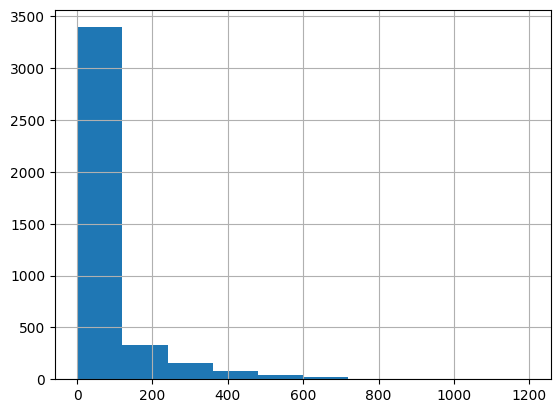

In [161]:
df['chars'].hist()

<Axes: >

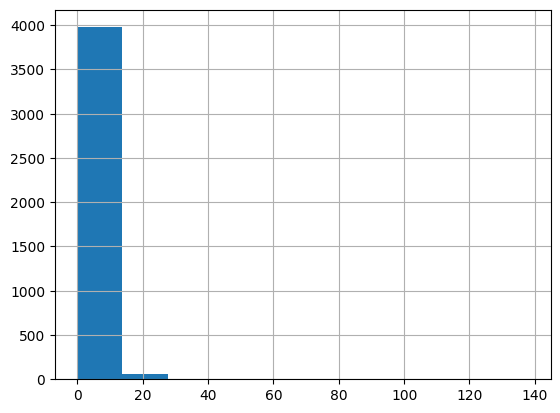

In [162]:
df['digit_count'].hist()

<Axes: >

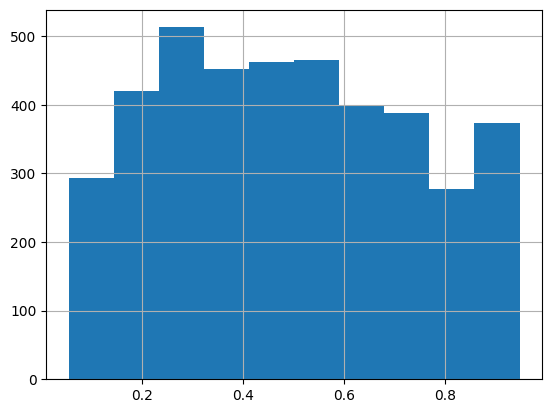

In [163]:
df['pos_y'].hist()

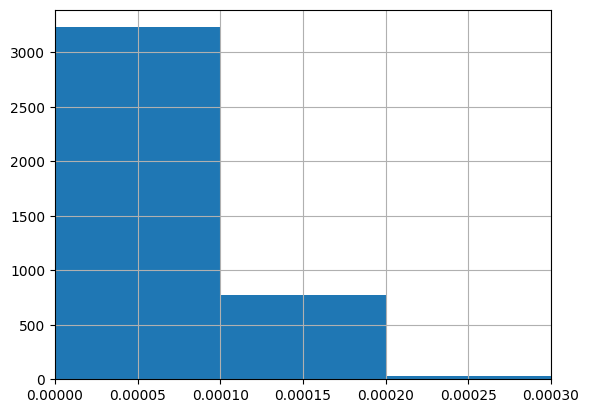

In [164]:
import pandas as pd
import matplotlib.pyplot as plt

# Tracer l'histogramme avec une limite sur l'axe x pour se concentrer sur les petites valeurs
ax = df['char_size'].hist(bins=50, range=(0,0.005))  # Ajustez le nombre de bins et la plage selon vos besoins

# Définir les limites de l'axe x si nécessaire
ax.set_xlim([0, 0.0003])  # Ajustez cette plage comme nécessaire

plt.show()

#**Fonction de Classification Automatique**

In [165]:
def classify_text(row):
    # These thresholds would need to be refined after inspecting the data
    title_threshold_char_size = 0.000075
    paragraph_min_chars = 60
    useless_pos_y_threshold_upper = 0.9
    useless_pos_y_threshold_lower = 0.06
    max_witdh=0.32
    max_chars=30

    if (row['pos_y'] < useless_pos_y_threshold_upper and row['pos_y'] > useless_pos_y_threshold_lower) and row['char_size'] > title_threshold_char_size and row['chars'] < paragraph_min_chars and row['digit_count'] in [0,1,2,3]:
        return 'Title'
    elif (row['pos_y'] < useless_pos_y_threshold_upper and row['pos_y'] > useless_pos_y_threshold_lower) and row['width'] > max_witdh and row['chars'] > row['digit_count']and row['chars'] > max_chars :
        return 'Paragraph'
    else:
        return 'Useless'

In [166]:
# Apply the classification function to each row
df['Label'] = df.apply(classify_text, axis=1)
df.to_excel("allianz_data.xlsx", index=False)

#**Visualisation des Résultats de Classification dans le PDF**

In [167]:

def draw_rectangles_in_pdf(pdf_path, df):
    # Ouvrez le document PDF
    doc = fitz.open(pdf_path)

    # Définir les couleurs pour chaque type de contenu
    # En PyMuPDF, les couleurs sont définies par des tuples (r, g, b) avec des valeurs de 0 à 1
    colors = {'Title': (0, 0, 1),  # Bleu
              'Paragraph': (0, 0, 0),  # Noir
              'Useless': (1, 0, 0)}  # Rouge

    # Parcourir chaque ligne du DataFrame et dessiner un rectangle pour chaque bloc
    for index, row in df.iterrows():
        page = doc[row['num_page'] - 1]

        # Si les coordonnées sont normalisées (valeur entre 0 et 1),
        # convertissez-les en coordonnées absolues
        x0 = row['x0'] * page.rect.width
        y0 = row['y0'] * page.rect.height
        x1 = row['x1'] * page.rect.width
        y1 = row['y1'] * page.rect.height


        # Créez un rectangle avec les coordonnées absolues
        rect = fitz.Rect(x0, y0, x1, y1)
        # Dessinez le rectangle avec un bord de couleur et remplissez partiellement transparent
        page.draw_rect(rect, color=colors[row['Label']], width=3.5, fill=colors[row['Label']], fill_opacity=0.3)

    # Enregistrez le PDF annoté
    output_pdf_path = "/content/drive/MyDrive/test-technique-main/data/results/annotated_{}.pdf".format(data_path)
    doc.save(output_pdf_path)
    doc.close()
    return output_pdf_path

# Le chemin vers votre fichier PDF
pdf_path ='/content/drive/MyDrive/test-technique-main/data/pdfs/{}.pdf'.format(data_path)   # Remplacez par le chemin correct
# Appliquez la fonction de dessin au PDF
annotated_pdf = draw_rectangles_in_pdf(pdf_path, df)